# Synthetic License Plate Image Generator
This tool can generate realistic license plate images for all 50 U.S. states with augmentations applied.  
Augmentations: Cutout, Occlude, Crop, Hue, Saturation, Exposure, Blur, Noise, Perspective Warp, Background.  
These augmentations will be randomly applied on a normal distribution with adjustable parameters.
#####  
Generated Images will be fully labeled, with optional per-char bounding boxes.  
PyTorch YOLOv5 data structure is implemented, but easily adjustable.

In [5]:
# Imports
import os
import math
import yaml
import time
import random
import string
import shutil
import colorsys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from IPython.display import clear_output
from PIL import Image, ImageDraw, ImageFont, ImageEnhance, ImageFilter, ImageOps
meta=pd.read_csv('config.csv')
# Generate map for indexs belonging to each state
# This ensures each state is equally distributed,
# Despite some states having more templates
index_map = {}
for idx, state in meta['STATE'].items():
    if state not in index_map:
        index_map[state] = []
    index_map[state].append(idx)
del idx,state

In [6]:
# This generates a random plate based off of config.csv
def get_plate(gen_bbox, draw_bbox):
    # Helper function to randomly select a state/template
    def pick_meta():
        # Randomly select a state
        random_state = random.choice(list(index_map.keys()))
        # Get all indices associated with that state
        indices = index_map[random_state]
        # Randomly select one of these indices
        return random.choice(indices)
    # Helper function to generate random text
    def generate_text(template):
        result = []
        for char in template:
            if char == '0': # Any number 0-9
                result.append(str(random.randint(0, 9)))
            elif char == 'A': # Any letter A-Z
                result.append(random.choice(string.ascii_uppercase))
            elif char == 'X': # Any char
                result.append(random.choice(string.ascii_uppercase + string.digits))
        return ''.join(result)
    # Helper function to draw text and get its bounding boxes (4 corners)
    def draw_text_with_bbox(x, y, text, font, fill):
        bboxes_list = []
        current_x = x
        for char in text:
            char_bbox = draw.textbbox((current_x, y), char, font=font)
            if gen_bbox:
                bbox_corners = (char_bbox[0], char_bbox[1], char_bbox[2], char_bbox[1], char_bbox[2], char_bbox[3], char_bbox[0], char_bbox[3])
                bboxes_list.append((char, bbox_corners))
            draw.text((current_x, y), char, font=font, fill=fill)
            if draw_bbox:
                draw.rectangle([char_bbox[0], char_bbox[1], char_bbox[2], char_bbox[3]], outline="red")
            current_x = char_bbox[2]
        return bboxes_list
    # Generation:
    DEFAULT_FONT_SIZE = 30 # To individually adjust use size modifier in config.csv
    row_index=pick_meta()
    row = meta.iloc[row_index]
    image_path = row['PATH'] # Get template
    img = Image.open(image_path)
    font_path = row['FONT'] # Get font
    font_color = tuple(map(int, row['RGB'].split(','))) # Get font color
    size_modifier = float(row['SIZE']) / 100.0 # Get font size
    font_size = int(DEFAULT_FONT_SIZE * size_modifier)
    font = ImageFont.truetype(font_path, font_size)
    state = row['STATE'] # Get state
    draw = ImageDraw.Draw(img)
    x_mov = int(row['X-MOV']) # Get x-offset
    y_mov = int(row['Y-MOV']) # Get y-offset
    char_bboxes = []
    # Process template with no center gap
    if pd.notna(row['CENTER']):
        center_text = row['CENTER']
        if set(center_text) == {'X'}:
            templates = ['X' * i for i in range(2, len(center_text) + 1)]
            chosen_template = random.choice(templates)
            text = generate_text(chosen_template)
        else:
            text = generate_text(center_text)
        text_bbox = draw.textbbox((0, 0), text, font=font)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]
        x = ((160 - text_width) // 2) + x_mov
        y = ((80 - text_height) // 2) + y_mov
        char_bboxes = draw_text_with_bbox(x, y, text, font, font_color)
    # Process template with center gap
    else:
        left_text = generate_text(row['LEFT'])
        right_text = generate_text(row['RIGHT'])
        space = row['SPACE']
        left_text_bbox = draw.textbbox((0, 0), left_text, font=font)
        right_text_bbox = draw.textbbox((0, 0), right_text, font=font)
        left_text_width = left_text_bbox[2] - left_text_bbox[0]
        right_text_width = right_text_bbox[2] - right_text_bbox[0]
        total_width = left_text_width + space + right_text_width
        y = ((80 - (left_text_bbox[3] - left_text_bbox[1])) // 2) + y_mov
        x_left = ((160 - total_width) // 2) + x_mov
        x_right = x_left + left_text_width + space
        char_bboxes += (draw_text_with_bbox(x_left, y, left_text, font, font_color))
        char_bboxes += (draw_text_with_bbox(x_right, y, right_text, font, font_color))
        text = left_text + ' ' + right_text
    return img, state, text, char_bboxes

# Augmentation Functions:

# Randomly cuts out segments in image on a normal distribution
def cutout(img, cstd, sstd):
    img_copy = img.copy()
    draw = ImageDraw.Draw(img_copy)
    num_cutouts = int(np.clip(abs(np.random.normal(1, cstd[0])), cstd[1], cstd[2]))
    for _ in range(num_cutouts):
        size = int(np.clip(abs(np.random.normal(1, sstd[0])), sstd[1], sstd[2]))
        # Generate random top-left coordinates for the cutout
        x = np.random.randint(0, img.width - size + 1)
        y = np.random.randint(0, img.height - size + 1)
        # Draw the cutout on the image
        draw.rectangle([x, y, x + size, y + size], fill='black')
    return img_copy
# Occlude sides on a normal distribution
def occlude(img, lrstd,tbstd):
    l = int( np.clip(np.random.normal(0, lrstd[0]), lrstd[1], lrstd[2]) )
    r = int( np.clip(np.random.normal(0, lrstd[0]), lrstd[1], lrstd[2]) )
    t = int( np.clip(np.random.normal(0, tbstd[0]), tbstd[1], tbstd[2]) )
    b = int( np.clip(np.random.normal(0, tbstd[0]), tbstd[1], tbstd[2]) )
    draw = ImageDraw.Draw(img)
    if l > 0:
        draw.rectangle([0, 0, l, 80], fill='black')
    if r > 0:
        draw.rectangle([160-r, 0, 160, 80], fill='black')
    if t > 0:
        draw.rectangle([0, 0, 160, t], fill='black')
    if b > 0:
        draw.rectangle([0, 80-b, 160, 80], fill='black')
    return img
# Crops (or extends) image sides on a normal distribution
def crop(img, lrstd, tbstd):
    l = int( np.clip(np.random.normal(0, lrstd[0]), lrstd[1], lrstd[2]) )
    r = int( np.clip(np.random.normal(0, lrstd[0]), lrstd[1], lrstd[2]) )
    t = int( np.clip(np.random.normal(0, tbstd[0]), tbstd[1], tbstd[2]) )
    b = int( np.clip(np.random.normal(0, tbstd[0]), tbstd[1], tbstd[2]) )
    extend_color = (51, 255, 51)
    # Calculate new boundaries
    left = 0 - l if l < 0 else l
    top = 0 - t if t < 0 else t
    right = img.width + r if r < 0 else img.width - r
    bottom = img.height + b if b < 0 else img.height - b
    new_width = right - left
    new_height = bottom - top
    new_img = Image.new("RGB", (new_width, new_height), extend_color)
    paste_x = 0 if l >= 0 else abs(l)
    paste_y = 0 if t >= 0 else abs(t)
    new_img.paste(img, (paste_x, paste_y))
    return new_img
# Adjust hue on a normal distribution
def hue(image,std):
    delta_hue = np.clip(np.random.normal(0, std[0]), std[1], std[2])
    img = image.convert('RGB')
    img_np = np.array(img)
    img_hsv = np.zeros(img_np.shape, dtype=float)
    for i in range(img_np.shape[0]):
        for j in range(img_np.shape[1]):
            r, g, b = img_np[i, j]
            h, s, v = colorsys.rgb_to_hsv(r/255., g/255., b/255.)
            h = (h + delta_hue/360.0) % 1.0
            img_hsv[i, j, :3] = colorsys.hsv_to_rgb(h, s, v)
    img_hsv = (img_hsv * 255).astype(np.uint8)
    return Image.fromarray(img_hsv, 'RGB')
# Adjust saturation on a normal distribution
def saturation(image, std):
    delta_saturation = np.clip(np.random.normal(1, std[0]), std[1], std[2])
    converter = ImageEnhance.Color(image)
    return converter.enhance(delta_saturation)
# Adjust brightness on a normal distribution
def exposure(image, std):
    delta_brightness = np.clip(np.random.normal(1, std[0]), std[1], std[2])
    converter = ImageEnhance.Brightness(image)
    return converter.enhance(delta_brightness)
# Add blur on a normal distribution
def blur(image, std):
    delta_blur = np.clip(abs(np.random.normal(0, std[0])), std[1], std[2])
    return image.filter(ImageFilter.GaussianBlur(radius=delta_blur))
# Add noise on a normal distribution
def noise(image, std):
    delta_noise = np.clip(abs(np.random.normal(0, std[0])), std[1], std[2])
    noise_array = np.random.normal(0, delta_noise, image.size[::-1])
    noisy_image = np.array(image) + noise_array[..., np.newaxis]
    return Image.fromarray(np.clip(noisy_image, 0, 255).astype(np.uint8))
# Add scaling, shear, rotation, and perspective warp on a normal distribution
def projective(image, coord_list, wparams):
    # Helper Function to Generate Projective Transformation Matrix
    def compute_homography():
        # Scale: Makes the image larger or smaller in each dimension.
        sx=np.clip((np.random.normal(1, SXstd)), SXmin, SXmax)# - (sx > 1, sy > 1) enlarges the image
        sy=np.clip((np.random.normal(1, SYstd)), SYmin, SYmax)# - (sx < 1, sy < 1) shrinks the image.
        S = np.array([[sx, 0, 0],[0, sy, 0],[0, 0, 1]])
        # Shear: Skews the image in a given direction.
        shx=np.clip((np.random.normal(0, SHXstd)), SHXmin, SHXmax)# - shx skews in the x direction
        shy=np.clip((np.random.normal(0, SHYstd)), SHYmin, SHYmax)# - shy in the y direction.
        SH = np.array([[1, shx, 0],[shy, 1, 0],[0, 0, 1]])
        # Rotation: Rotates the image around the origin.
        rotation = np.deg2rad(np.clip((np.random.normal(0, Rstd)), Rmin, Rmax))
        R = np.array([[np.cos(rotation), -np.sin(rotation), 0],[np.sin(rotation), np.cos(rotation), 0],[0, 0, 1]])
        # Projective warp: Creates a perspective effect.
        # - w0 and w1 define the projective intensity in the x and y directions respectively.
        px=np.clip((np.random.normal(0, PXstd)), PXmin, PXmax)
        py=np.clip((np.random.normal(0, PYstd)), PYmin, PYmax)
        P = np.array([[1, 0, 0],[0, 1, 0],[px, py, 1]])
        # Combine transformations
        H = P @ R @ SH @ S
        return H
    og_w,og_h=image.size
    SXstd, SXmin, SXmax = wparams["SXstd"], wparams["SXmin"], wparams["SXmax"]
    SYstd, SYmin, SYmax = wparams["SYstd"], wparams["SYmin"], wparams["SYmax"]
    SHXstd, SHXmin, SHXmax = wparams["SHXstd"], wparams["SHXmin"], wparams["SHXmax"]
    SHYstd, SHYmin, SHYmax = wparams["SHYstd"], wparams["SHYmin"], wparams["SHYmax"]
    Rstd, Rmin, Rmax = wparams["Rstd"], wparams["Rmin"], wparams["Rmax"]
    PXstd, PXmin, PXmax = wparams["PXstd"], wparams["PXmin"], wparams["PXmax"]
    PYstd, PYmin, PYmax = wparams["PYstd"], wparams["PYmin"], wparams["PYmax"]
    matrix = compute_homography()
    inv_matrix = np.linalg.inv(matrix)
    # Step 1: Transform the corners of the image
    corners = np.array([[0, 0, 1],[159, 0, 1],[159, 79, 1],[0, 79, 1]])
    transformed_corners = np.dot(corners, matrix.T)
    transformed_corners = transformed_corners[:, :2] / transformed_corners[:, 2, np.newaxis]
    # Step 2: Determine a new coordinate frame
    min_x = np.min(transformed_corners[:, 0])
    min_y = np.min(transformed_corners[:, 1])
    max_x = np.max(transformed_corners[:, 0])
    max_y = np.max(transformed_corners[:, 1])
    width = int(max_x - min_x)
    height = int(max_y - min_y)
    # Step 3: Create output canvas in this coordinate frame
    output_canvas = Image.new('RGB', (width, height), (51, 255, 51))
    for x in range(width):
        for y in range(height):
            orig_x, orig_y, w = np.dot([x + min_x, y + min_y, 1], inv_matrix.T)
            orig_x /= w
            orig_y /= w
            if 0 <= orig_x < og_w and 0 <= orig_y < og_h:
                output_canvas.putpixel((x, y), image.getpixel((int(orig_x), int(orig_y))))
    # Step 4: Transform bbox coordinates
    transformed_list = []

    for char, bbox in coord_list:
        transformed_coords_set = np.array([[bbox[i], bbox[i+1], 1] for i in range(0, len(bbox), 2)])
        transformed_coords_set = np.dot(transformed_coords_set, matrix.T)
        transformed_coords_set = transformed_coords_set[:, :2] / transformed_coords_set[:, 2, np.newaxis]
        # Adjust to the new coordinate frame
        transformed_coords_set[:, 0] -= min_x
        transformed_coords_set[:, 1] -= min_y
        transformed_list.append((char, transformed_coords_set.flatten().tolist()))

    return output_canvas, transformed_list
# Function to replace background
def background(img):
    data = np.array(img)
    mask = (data[:, :, 0] == 51) & (data[:, :, 1] == 255) & (data[:, :, 2] == 51)
    data[mask] = np.random.randint(0, 256, size=(mask.sum(), 3))
    return Image.fromarray(data)
# Function to pad the image to 160x160
def pad(image, boxes):
    new_image = Image.new("RGB", (160, 160), color=(0, 0, 0))
    new_image.paste(image, (0, 0))
    adjusted_boxes = []
    for box in boxes:
        adjusted_box = box.copy()
        adjusted_box['y'] /= 2
        adjusted_box['height'] /= 2
        adjusted_boxes.append(adjusted_box)
    return new_image, adjusted_boxes

# Generate a batch of 100 randomly generated & augmented license plates
def get_batch(params, warp_params, display_images, display_boxes):
    # Helper function to process boxes into x, y, width, height format
    def bounding_boxes(image, boxes_list, display_boxes):
        w, h = image.size
        positions = []
        draw = ImageDraw.Draw(image)
        for char, box in boxes_list:
            x_coords = box[0::2]
            y_coords = box[1::2]
            xmin = min(x_coords)
            xmax = max(x_coords)
            ymin = min(y_coords)
            ymax = max(y_coords)
            x = ((xmin + xmax) / 2) / w
            y = ((ymin + ymax) / 2) / h
            width = (xmax - xmin) / w
            height = (ymax - ymin) / h
            positions.append({"char": char, "x": x, "y": y, "width": width, "height": height})
            if display_boxes:
                draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=2)
        return image, positions
    # Generate 100 plates
    batch_data = []
    Cstd, Cmin, Cmax = params["Cstd"], params["Cmin"], params["Cmax"]
    Sistd, Simin, Simax = params["Sistd"], params["Simin"], params["Simax"]
    Olrstd, Olrmin, Olrmax = params["Olrstd"], params["Olrmin"], params["Olrmax"]
    Otbstd, Otbmin, Otbmax = params["Otbstd"], params["Otbmin"], params["Otbmax"]
    Clrstd, Clrmin, Clrmax = params["Clrstd"], params["Clrmin"], params["Clrmax"]
    Ctbstd, Ctbmin, Ctbmax = params["Ctbstd"], params["Ctbmin"], params["Ctbmax"]
    Hstd, Hmin, Hmax = params["Hstd"], params["Hmin"], params["Hmax"]
    Sstd, Smin, Smax = params["Sstd"], params["Smin"], params["Smax"]
    Estd, Emin, Emax = params["Estd"], params["Emin"], params["Emax"]
    Bstd, Bmin, Bmax = params["Bstd"], params["Bmin"], params["Bmax"]
    Nstd, Nmin, Nmax = params["Nstd"], params["Nmin"], params["Nmax"]
    for _ in range(100):
        # Get Random Plate
        img, state, text, boxes= get_plate(True,False) # Dont draw boxes on plate by default
        # Image Augmentations
        img = cutout(img, (Cstd, Cmin, Cmax), (Sistd, Simin, Simax))
        img = occlude(img, (Olrstd,Olrmin,Olrmax), (Otbstd,Otbmin,Otbmax))
        img = crop(img, (Clrstd,Clrmin,Clrmax), (Ctbstd,Ctbmin,Ctbmax))
        img = hue(img, (Hstd, Hmin, Hmax))
        img = saturation(img, (Sstd, Smin, Smax))
        img = exposure(img, (Estd, Emin, Emax))
        img = blur(img, (Bstd, Bmin, Bmax))
        img = noise(img, (Nstd, Nmin, Nmax))
        img, boxes = projective(img, boxes, warp_params)
        img = background(img)
        # Process Boxes
        img, positions = bounding_boxes(img,boxes,display_boxes)
        img=img.resize((160, 80))
        # Prepare image for YOLO
        img, positions = pad(img, positions)
        data = {'image': img, 'state': state, 'boxes': positions, 'plate': text}
        batch_data.append(data)
    # Display the 100 plates in a 10x0 grid
    if(display_images):
        fig, axes = plt.subplots(10, 10, figsize=(25, 25))
        for ax, item in zip(axes.ravel(), batch_data):
            ax.imshow(item['image'])
            ax.axis('off')
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.show()
    return batch_data

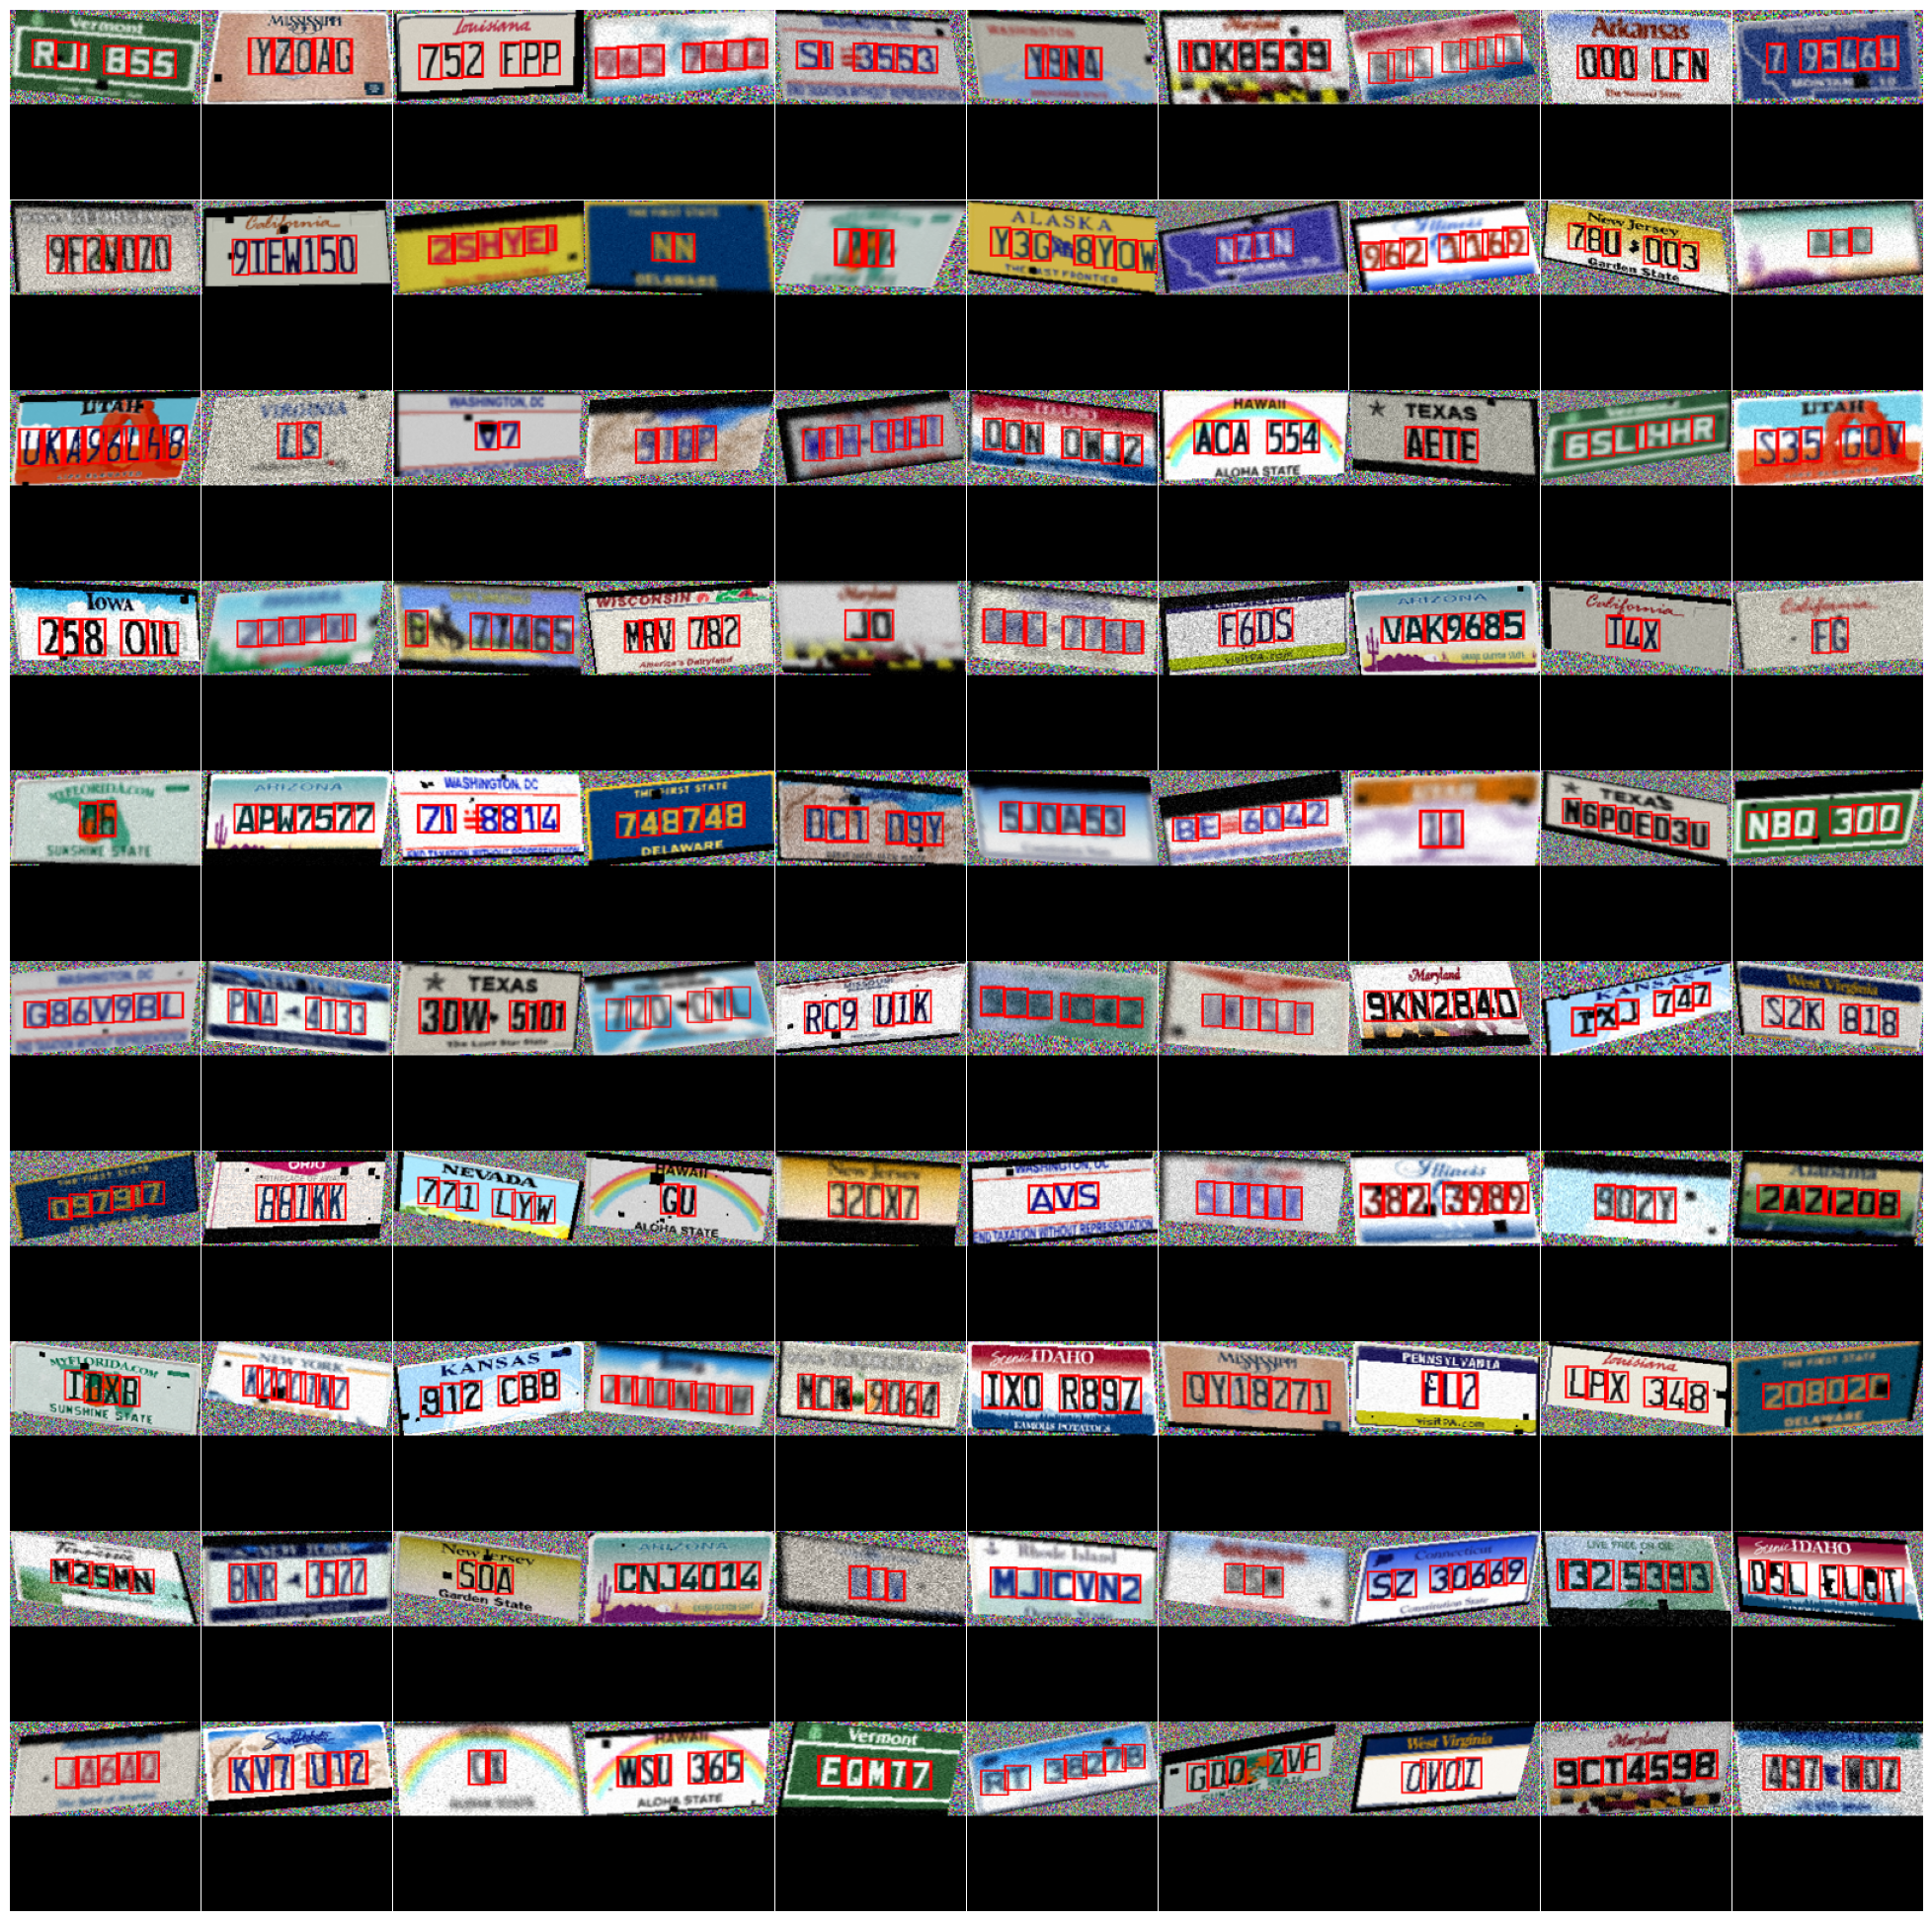

In [9]:
# Test Generation of one batch of 100 images.

# Augmentation Standard Deviation, Min, Max Adjustments
params = {
    "Cstd": 4, "Cmin": 0, "Cmax":15, # Count of cut-out boxes
    "Sistd": 5, "Simin": 1, "Simax": 15, # Size of cut-out boxes
    "Olrstd": 3, "Olrmin": 0, "Olrmax": 15, # Occluding left/right sides
    "Otbstd": 8, "Otbmin": 0, "Otbmax": 25, # Occluding top/bottom sides
    "Clrstd": 3, "Clrmin": 0, "Clrmax": 15, # Cropping/extending left/right sides
    "Ctbstd": 5, "Ctbmin": 0, "Ctbmax": 25, # Cropping/extending top/bottom sides
    "Hstd": 7, "Hmin": -25, "Hmax": 25, # Hue
    "Sstd": .1, "Smin": .6, "Smax": 1.4, # Saturation ( Mean = 1 )
    "Estd": .1, "Emin": .5, "Emax": 1.5, # Exposure
    "Bstd": 1.5, "Bmin": 0, "Bmax": 3, # Blur
    "Nstd": 15, "Nmin": 0, "Nmax": 50} # Noise
warp_params = {  
    "SXstd": .2, "SXmin": .4, "SXmax": 1.6, # Scale X
    "SYstd": .2, "SYmin": .4, "SYmax": 1.6, # Scale Y
    "SHXstd": .08, "SHXmin": -.25, "SHXmax": .25, # Shear X
    "SHYstd": .08, "SHYmin": -.25, "SHYmax": .25, # Shear Y
    "Rstd": 2, "Rmin": -10, "Rmax": 10, # Rotation (Degrees)
    "PXstd": .0005, "PXmin": -.004, "PXmax": .004, # Perspective X
    "PYstd": .0005, "PYmin": -.004, "PYmax": .004} # Perspective Y
DISPLAY_IMAGES = True
DISPLAY_BOXES = True
test=get_batch(params,warp_params, DISPLAY_IMAGES, DISPLAY_BOXES) 

In [ ]:
# Generate PyTorch YoloV5 ready data
NUM_SAMPLES = 1000
TRAIN = .85
VAL = .1
TEST = .05
DISPLAY_IMAGES = True
DISPLAY_BOXES = False
ROOT_DIR = '/'
# Create required structure
def represent_list(dumper, data):
    """YAML representer to represent lists in one line."""
    return dumper.represent_sequence(u'tag:yaml.org,2002:seq', data, flow_style=True)
yaml.add_representer(list, represent_list)
# Create main directories
main_dir = os.path.join(ROOT_DIR, "custom_data")
train_dir = os.path.join(main_dir, "train")
valid_dir = os.path.join(main_dir, "valid")
test_dir = os.path.join(main_dir, "test")
if os.path.exists(main_dir):
    shutil.rmtree(main_dir)
os.makedirs(main_dir, exist_ok=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
for directory in [train_dir, valid_dir, test_dir]:
    os.makedirs(os.path.join(directory, "images"), exist_ok=True)
    os.makedirs(os.path.join(directory, "labels"), exist_ok=True)
names_list = [str(i) for i in range(10)] + [chr(i) for i in range(97, 123)]  # digits 0-9 and letters a-z
names_mapping = {char: idx for idx, char in enumerate(names_list)}
nc = len(names_list)
data_dict = {
    'train': '../train/images',
    'val': '../valid/images',
    'test': '../test/images',
    'nc': nc,
    'names': names_list}
with open(os.path.join(main_dir, "data.yaml"), 'w') as f:
    yaml.dump(data_dict, f, sort_keys=False)
# Generate & Store Data
count = 0
# Extend names_mapping for uppercase letters
for idx, char in enumerate(names_list[10:]):  # For characters a-z in names_list
    uppercase_char = char.upper()
    names_mapping[uppercase_char] = idx + 10  # Adding 10 to skip the digits
# Calculate the batch split sizes
num_train = int( 100 * TRAIN )
num_val = int( 100 * VAL)
num_test = int( 100 * TEST)
bounding_box_dims = [] ###########
for _ in range (int(NUM_SAMPLES/100)):
    # Call get_batch
    clear_output(wait=True)
    time.sleep(.1)
    batch = get_batch(params, warp_params, DISPLAY_IMAGES, DISPLAY_BOXES)
    for index, item in enumerate(batch):
        if index < num_train:
            directory = train_dir
        elif index < num_train + num_val:
            directory = valid_dir
        else:
            directory = test_dir
        image_dir = os.path.join(directory, "images")
        label_dir = os.path.join(directory, "labels")
        # Save Image
        image_name = f"{count}_{item['state']}_{item['plate'].replace(' ', '-')}.jpg"
        image_path = os.path.join(image_dir, image_name)
        item['image'].save(image_path)
        # Save Labels 
        label_name = f"{count}_{item['state']}_{item['plate'].replace(' ', '-')}.txt"
        label_path = os.path.join(label_dir, label_name)
        with open(label_path, 'w') as txt_file:
            for box in item['boxes']:
                char_idx = names_mapping[box['char']]
                line = f"{char_idx} {box['x']} {box['y']} {box['width']} {box['height']}\n"
                txt_file.write(line)
                bounding_box_dims.append((box['width'], box['height']))
        count += 1